In [1]:
import json

import numpy as np
import pandas as pd
import altair as alt
from altair import datum

In [2]:
data = pd.read_excel("Data/Ne phase shift diffs.xlsx", sheet_name="Perturb")
data.head()

,Method,Photon energy (eV),KE (eV),Config,Polar ang (rad),Polar ang (deg),Phase shift (rad),Phase shift (deg)
0,Perturbation,14.0,3.412611,sum[m],0.0,0.0,0.875245,50.147846
1,Perturbation,14.1,3.612611,sum[m],0.0,0.0,0.880115,50.426903
2,Perturbation,14.2,3.812611,sum[m],0.0,0.0,0.884867,50.699156
3,Perturbation,14.3,4.012611,sum[m],0.0,0.0,0.889499,50.964543
4,Perturbation,14.4,4.212611,sum[m],0.0,0.0,0.894009,51.222948


In [4]:
def f(df):
    where = (df["Photon energy (eV)"] < 16.85) & ~df["Phase shift (rad)"].isna()
    if where.sum() != 0:
        y = np.unwrap(df.loc[where, "Phase shift (rad)"])
        df.loc[where, "Phase shift (rad)"] = y

    where = ~(df["Photon energy (eV)"] < 16.85) & ~df["Phase shift (rad)"].isna()
    if where.sum() != 0:
        y = np.unwrap(df.loc[where, "Phase shift (rad)"])
        df.loc[where, "Phase shift (rad)"] = y - (y[0] - 0.8) // (2 * np.pi) * (2 * np.pi)
    df["Phase shift (deg)"] = df["Phase shift (rad)"] / np.pi * 180
    return df


unwrapped = (
    data
    .set_index(["Polar ang (rad)", "Photon energy (eV)"])
    .sort_index()
    .reset_index()
    .groupby("Polar ang (rad)")
    .apply(f)
)
# unwrapped.to_excel("a.xlsx")
unwrapped.head()

,Polar ang (rad),Photon energy (eV),Method,KE (eV),Config,Polar ang (deg),Phase shift (rad),Phase shift (deg)
0,0.0,14.0,Perturbation,3.412611,sum[m],0.0,0.875245,50.147846
1,0.0,14.1,Perturbation,3.612611,sum[m],0.0,0.880115,50.426903
2,0.0,14.2,Perturbation,3.812611,sum[m],0.0,0.884867,50.699156
3,0.0,14.3,Perturbation,4.012611,sum[m],0.0,0.889499,50.964543
4,0.0,14.4,Perturbation,4.212611,sum[m],0.0,0.894009,51.222948


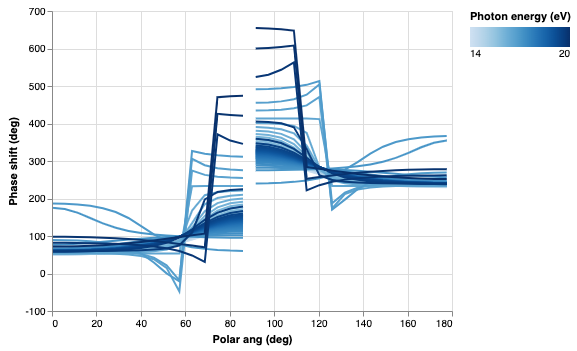

In [5]:
df = unwrapped
(
    alt
    .Chart(df)
    .mark_line()
    .encode(
        x="Polar ang (deg):Q",
        y="Phase shift (deg):Q",
        color="Photon energy (eV):Q",
        )
)

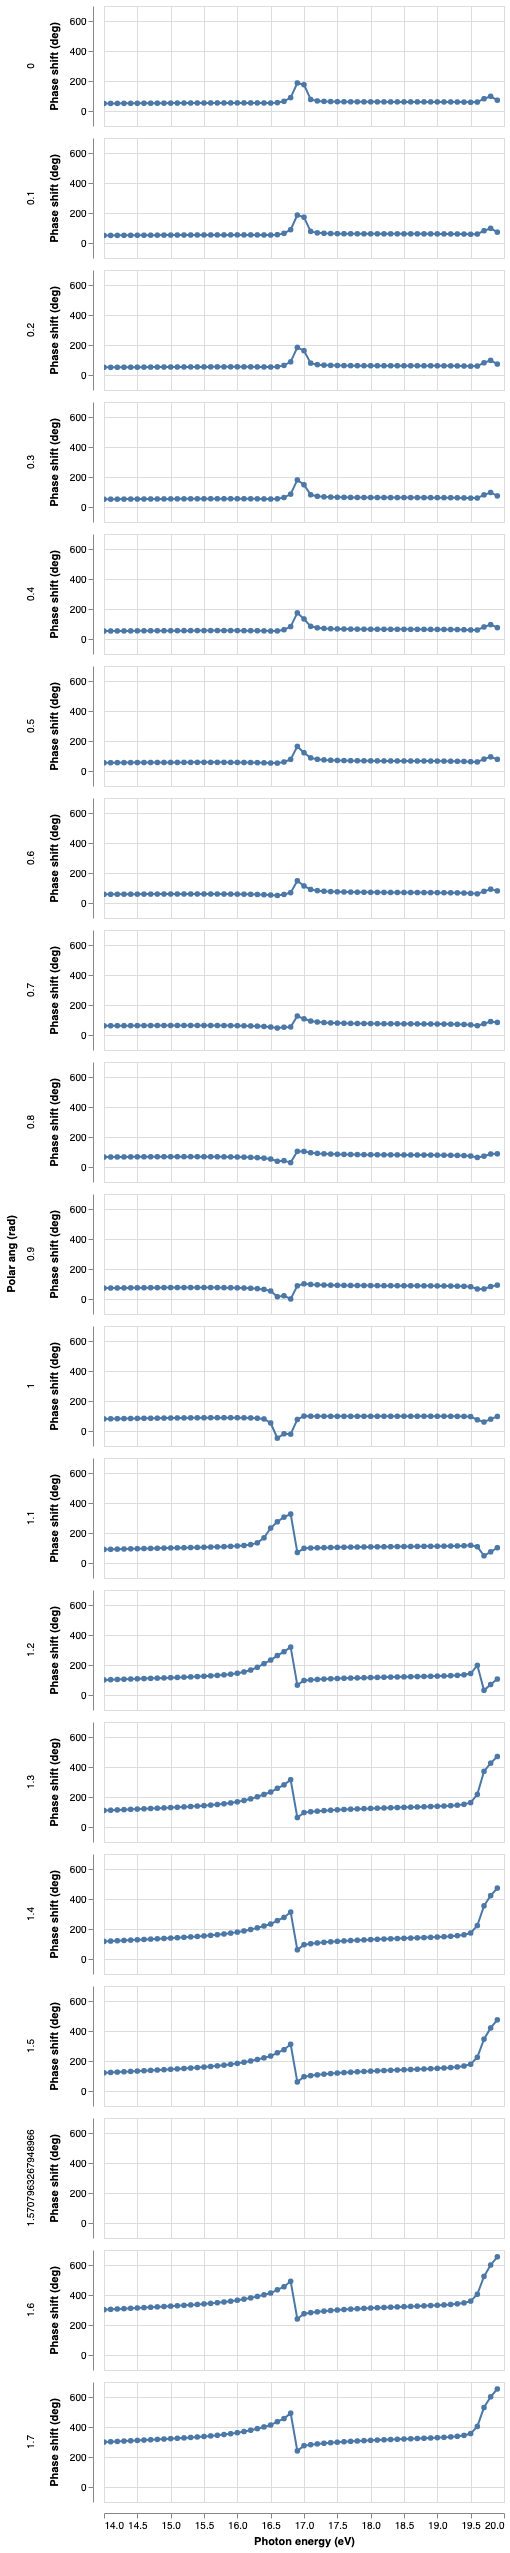

In [6]:
df = unwrapped[unwrapped["Polar ang (deg)"] < 100]
(
    alt
    .Chart(df)
    .mark_line(point=True)
    .encode(
        x="Photon energy (eV):Q",
        y="Phase shift (deg):Q",
        row="Polar ang (rad):N",
        )
    .properties(height=120)
    .interactive(bind_x=False)
)

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# %matplotlib notebook

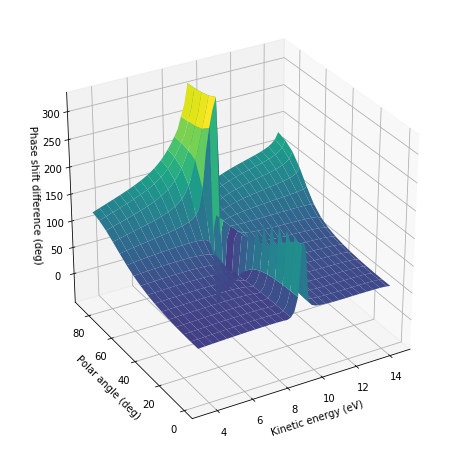

In [10]:
tab = (
    unwrapped[(unwrapped["Polar ang (deg)"] < 90)
              & (unwrapped["Photon energy (eV)"] < 19.5)]
    .pivot(index="Polar ang (deg)", columns="KE (eV)", values="Phase shift (deg)")
)
x, y = np.meshgrid(tab.columns, tab.index)

fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.set_xlabel("Kinetic energy (eV)")
ax.set_ylabel("Polar angle (deg)")
ax.set_zlabel("Phase shift difference (deg)")
ax.plot_surface(x, y, tab.values, cmap='viridis')
ax.view_init(None, 240)
# plt.savefig("Figures/Ne phase shift diffs - Perturb - 3D.pdf")
plt.show()

In [14]:
def f(df):
    x = 2 * df["Photon energy (eV)"] / 24.1888432651  # Ry
    y = df["Phase shift (rad)"]
    dy = np.gradient(y, x)
    df["EWS delay (as)"] = dy / 0.0367493
    return df


diff = (
    unwrapped[unwrapped["Photon energy (eV)"] < 16.5]
    .set_index(["Polar ang (rad)", "Photon energy (eV)"])
    .sort_index()
    .reset_index()
    .groupby("Polar ang (rad)")
    .apply(f)
)
diff.head()

,Polar ang (rad),Photon energy (eV),Method,KE (eV),Config,Polar ang (deg),Phase shift (rad),Phase shift (deg),EWS delay (as)
0,0.0,14.0,Perturbation,3.412611,sum[m],0.0,0.875245,50.147846,16.028981
1,0.0,14.1,Perturbation,3.612611,sum[m],0.0,0.880115,50.426903,15.833578
2,0.0,14.2,Perturbation,3.812611,sum[m],0.0,0.884867,50.699156,15.440985
3,0.0,14.3,Perturbation,4.012611,sum[m],0.0,0.889499,50.964543,15.043290
4,0.0,14.4,Perturbation,4.212611,sum[m],0.0,0.894009,51.222948,14.638732


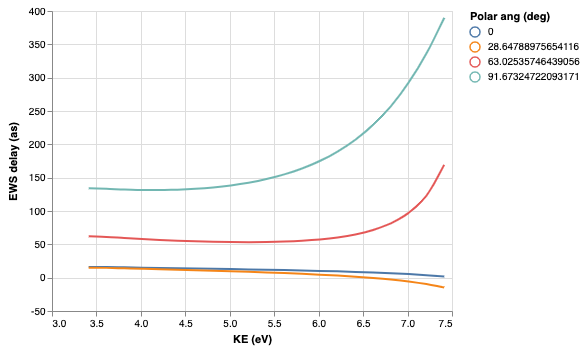

In [17]:
df = diff[(diff["Photon energy (eV)"] < 16)
          & diff["Polar ang (rad)"].isin({0, 0.5, 1.1, 1.6})]
(
    alt
    .Chart(df)
    .mark_line(interpolate="monotone")
    .encode(
        x="KE (eV):Q",
        y="EWS delay (as):Q",
        color=alt.Color("Polar ang (deg):N", legend=alt.Legend(format=".0f")),
        )
    .interactive(bind_x=False)
)

In [7]:
data = pd.read_excel("Data/Ne EWS delay diffs.xlsx", sheet_name="Perturb")
data = data[data["Photon energy to (eV)"].isna()]
data.head()

,Method,Photon energy fr (eV),Photon energy to (eV),KE range (eV),KE (eV),Polar ang (deg),EWS delay (as)
0,Perturbation,14.3,NaN,~04.0,4.012611,0.000000,16.369726
1,Perturbation,14.3,NaN,~04.0,4.012611,0.572958,16.368726
2,Perturbation,14.3,NaN,~04.0,4.012611,1.145916,16.365725
3,Perturbation,14.3,NaN,~04.0,4.012611,1.718873,16.360726
4,Perturbation,14.3,NaN,~04.0,4.012611,2.291831,16.353733


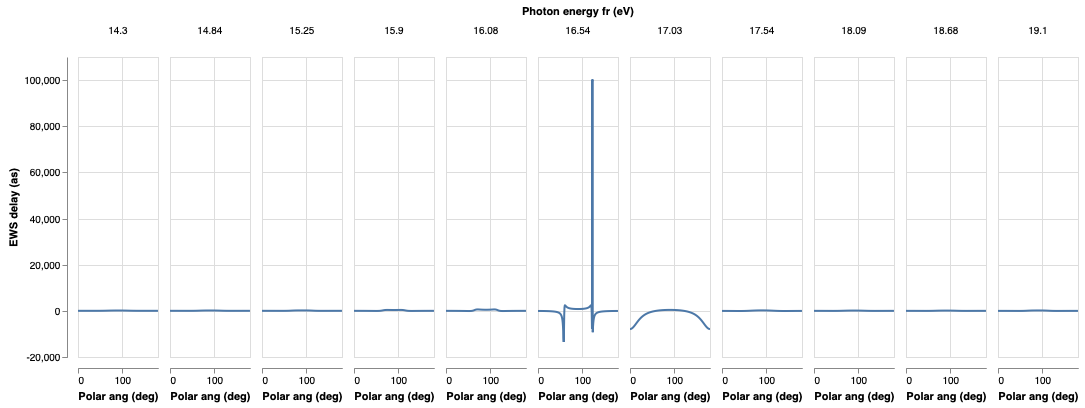

In [8]:
(
    alt
    .Chart(data)
    .mark_line()
    .encode(
        x="Polar ang (deg):Q",
        y="EWS delay (as):Q",
        column="Photon energy fr (eV):N",
        )
#     .transform_filter(datum["Photon energy fr (eV)"] == 16.54)
    .properties(width=80)
    .interactive(bind_x=False)
)

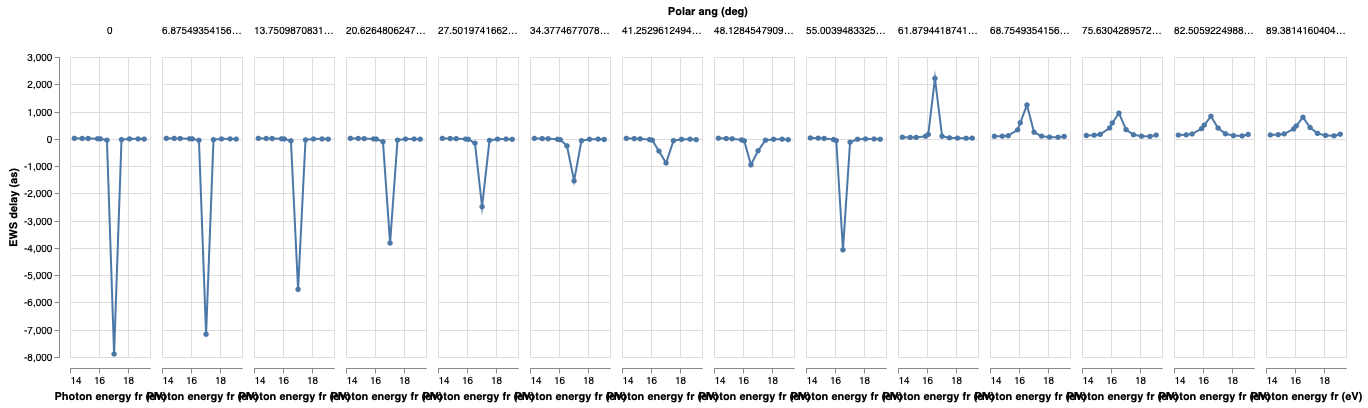

In [11]:
roi = data["Polar ang (deg)"].unique()[::12]
df = data[data["Polar ang (deg)"].isin(roi) & (data["Polar ang (deg)"] < 90)]
# df = data[(89.5 < data["Polar ang (deg)"]) & (data["Polar ang (deg)"] < 90)]
(
    alt
    .Chart(df)
    .mark_line(point=True)
    .encode(
        x="Photon energy fr (eV):Q",
        y="EWS delay (as):Q",
        column="Polar ang (deg):N",
        )
    .properties(width=80)
    .interactive(bind_x=False)
)